In [1]:
import numpy as np 
import pandas as pd
from matplotlib import pyplot as plt

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split

In [2]:
path = "/kaggle/input/airbnb-price-determinants-in-europe/barcelona_weekdays.csv"
df = pd.read_csv(path, index_col=0)
df.head()

,realSum,room_type,room_shared,room_private,person_capacity,host_is_superhost,multi,biz,cleanliness_rating,guest_satisfaction_overall,bedrooms,dist,metro_dist,attr_index,attr_index_norm,rest_index,rest_index_norm,lng,lat
0,474.317499,Entire home/apt,False,False,4.0,False,0,1,10.0,91.0,1,1.111996,0.630491,526.469420,17.942927,915.587083,20.154890,2.17556,41.39624
1,169.897829,Private room,False,True,2.0,True,1,0,10.0,88.0,1,1.751839,0.124017,320.127526,10.910462,794.277350,17.484489,2.14906,41.38714
2,161.984779,Private room,False,True,4.0,False,0,1,9.0,88.0,1,1.670493,0.080322,344.073936,11.726595,840.673617,18.505814,2.15357,41.37859
3,367.956804,Entire home/apt,False,False,3.0,False,0,1,10.0,91.0,1,1.475847,0.093107,400.057449,13.634603,946.589884,20.837357,2.16839,41.37390
4,196.895292,Private room,False,True,3.0,False,1,0,9.0,91.0,1,1.855452,0.272486,346.042245,11.793678,792.296039,17.440874,2.15238,41.37699


# Data Preposessing

## Add data shuffle

In [3]:
np.random.seed(144)
df = df.sample(frac=1).reset_index(drop=True)

## DEALING WITH MISSING VALUES

In [4]:
df.describe()

,realSum,person_capacity,multi,biz,cleanliness_rating,guest_satisfaction_overall,bedrooms,dist,metro_dist,attr_index,attr_index_norm,rest_index,rest_index_norm,lng,lat
count,1555.000000,1555.000000,1555.000000,1555.000000,1555.000000,1555.000000,1555.000000,1555.000000,1555.000000,1555.000000,1555.000000,1555.000000,1555.000000,1555.000000,1555.000000
mean,288.391667,2.756270,0.376849,0.350482,9.285531,90.929260,1.216720,2.117302,0.434875,464.371805,15.826540,877.664048,19.320087,2.168975,41.393308
std,321.180435,1.276615,0.484752,0.477275,1.007445,8.695707,0.569475,1.351517,0.275846,268.318982,9.144744,461.294504,10.154512,0.019657,0.015947
min,69.588289,2.000000,0.000000,0.000000,2.000000,20.000000,0.000000,0.119903,0.013004,93.820461,3.197553,159.835498,3.518471,2.105190,41.349540
25%,161.984779,2.000000,0.000000,0.000000,9.000000,88.000000,1.000000,1.090570,0.252128,282.772255,9.637335,494.391320,10.883075,2.156000,41.381215
50%,208.532129,2.000000,0.000000,0.000000,10.000000,93.000000,1.000000,1.751839,0.370507,389.198464,13.264511,801.812049,17.650351,2.170710,41.390360
75%,335.373659,3.000000,1.000000,1.000000,10.000000,97.000000,1.000000,2.949202,0.554220,591.594276,20.162487,1211.256634,26.663486,2.179375,41.404000
max,6943.700980,6.000000,1.000000,1.000000,10.000000,100.000000,6.000000,8.443957,2.402779,2934.133441,100.000000,4542.754150,100.000000,2.225520,41.463080


In [5]:
df.shape

(1555, 19)

In [6]:
df_complete = df.dropna()
df_complete.shape

(1555, 19)

## FINDING OUTLIERS

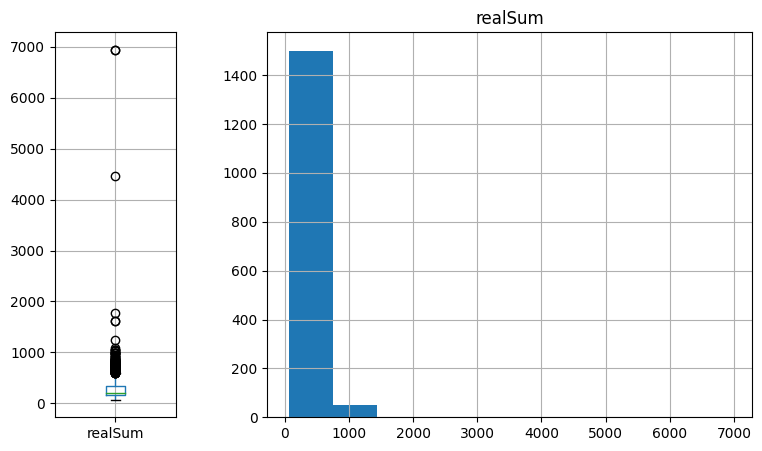

In [7]:
fig, axes= plt.subplots(1,2, gridspec_kw={'width_ratios': [1, 4]}, figsize=(9,5))
df.boxplot(column='realSum',ax=axes[0]);
df.hist(column='realSum', ax=axes[1]);

In [8]:
Q1 = df['realSum'].quantile(0.25)
Q3 = df['realSum'].quantile(0.75)
IQR = Q3 - Q1

Q1, Q3, IQR

(161.98477901645447, 335.3736588544697, 173.3888798380152)

In [9]:
small_outliers = df['realSum'] < (Q1 - 1.5 * IQR)
big_outliers = df['realSum'] > (Q3 + 1.5 * IQR)

sum(small_outliers), sum(big_outliers)

(0, 117)

In [10]:
df['realSum'][small_outliers | big_outliers].head()

0      780.133591
37    1041.729700
39     729.164242
43     601.624503
79     790.374008
Name: realSum, dtype: float64

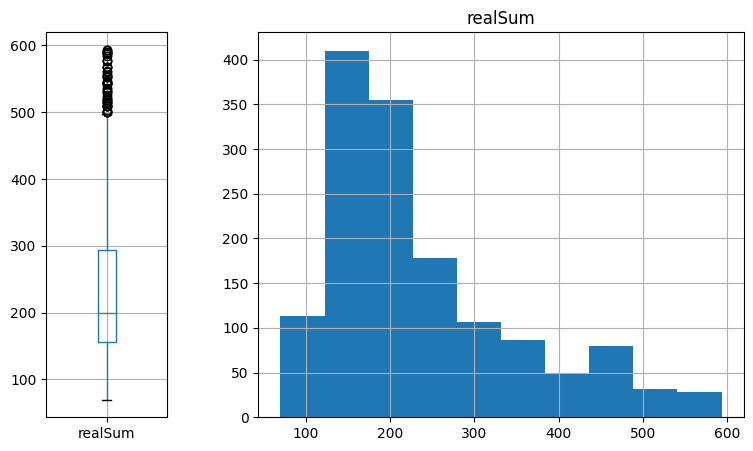

In [11]:
fig, axes= plt.subplots(1,2, gridspec_kw={'width_ratios': [1, 4]}, figsize=(9,5))
df[~(small_outliers | big_outliers)].boxplot(column='realSum',ax=axes[0]);
df[~(small_outliers | big_outliers)].hist(column='realSum', ax=axes[1]);

In [12]:
df_clean = df[~(small_outliers | big_outliers)]
df_clean.shape

(1438, 19)

In [13]:
df_clean.dtypes

realSum                       float64
room_type                      object
room_shared                      bool
room_private                     bool
person_capacity               float64
host_is_superhost                bool
multi                           int64
biz                             int64
cleanliness_rating            float64
guest_satisfaction_overall    float64
bedrooms                        int64
dist                          float64
metro_dist                    float64
attr_index                    float64
attr_index_norm               float64
rest_index                    float64
rest_index_norm               float64
lng                           float64
lat                           float64
dtype: object

In [14]:
# Identifying categorical and numerical columns
categorical_cols = [col for col in df_clean.columns if df_clean[col].dtype in ['object', 'bool']]
numerical_cols = [col for col in df_clean.columns if df_clean[col].dtype in ['int64', 'float64'] and col != 'realSum']

# Adjust transformers if necessary
categorical_transformer = OneHotEncoder(handle_unknown='ignore')
numerical_transformer = StandardScaler()

# Update preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

# Fit and transform the data
df_transformed = preprocessor.fit_transform(df_clean.drop('realSum', axis=1))

# Check transformed feature names and dimensions
transformed_features = preprocessor.transformers_[0][1].get_feature_names_out(numerical_cols).tolist() + \
                       preprocessor.transformers_[1][1].get_feature_names_out(categorical_cols).tolist()

print(transformed_features)
print(df_transformed.shape)

['person_capacity', 'multi', 'biz', 'cleanliness_rating', 'guest_satisfaction_overall', 'bedrooms', 'dist', 'metro_dist', 'attr_index', 'attr_index_norm', 'rest_index', 'rest_index_norm', 'lng', 'lat', 'room_type_Entire home/apt', 'room_type_Private room', 'room_type_Shared room', 'room_shared_False', 'room_shared_True', 'room_private_False', 'room_private_True', 'host_is_superhost_False', 'host_is_superhost_True']
(1438, 23)


# Prepare Training Data

In [15]:
# y = df_clean['realSum'].values

# # Create Train Data and Test Data
# X_train, X_test, y_train, y_test = train_test_split(df_transformed, y, test_size=0.2, random_state=42)
# X_train = torch.tensor(X_train, dtype=torch.float32)
# X_test = torch.tensor(X_test, dtype=torch.float32)
# y_train = torch.tensor(y_train, dtype=torch.float32)
# y_test = torch.tensor(y_test, dtype=torch.float32)

# # Create DataLoader
# train_dataset = TensorDataset(X_train, y_train)
# test_dataset = TensorDataset(X_test, y_test)

# train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
# test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [16]:
y = df_clean['realSum'].values

# Split Test Data
X_train_val, X_test, y_train_val, y_test = train_test_split(df_transformed, y, test_size=0.2, random_state=42)

# Split Validation Data
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=42) 

train_dataset = TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.float32))
val_dataset = TensorDataset(torch.tensor(X_val, dtype=torch.float32), torch.tensor(y_val, dtype=torch.float32))
test_dataset = TensorDataset(torch.tensor(X_test, dtype=torch.float32), torch.tensor(y_test, dtype=torch.float32))

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Define SVM Model

In [17]:
class SVR(nn.Module):
    def __init__(self, n_features):
        super(SVR, self).__init__()
        self.linear = nn.Linear(n_features, 1)

    def forward(self, x):
        return self.linear(x)

In [18]:
def epsilon_insensitive_loss(outputs, targets, epsilon=0.1):
    errors = torch.abs(targets - outputs.squeeze())

    loss = torch.mean(torch.max(errors - epsilon, torch.zeros_like(errors)))
    return loss

In [19]:
model = SVR(X_train.shape[1])

In [20]:
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, weight_decay=0.01)

In [21]:
class EarlyStopping:
    def __init__(self, patience=10, verbose=False, delta=0):
        self.patience = patience
        self.verbose = verbose
        self.delta = delta
        self.best_score = None
        self.epochs_no_improve = 0
        self.early_stop = False

    def __call__(self, val_loss):
        score = -val_loss

        if self.best_score is None:
            self.best_score = score
        elif score < self.best_score + self.delta:
            self.epochs_no_improve += 1
            if self.epochs_no_improve >= self.patience:
                self.early_stop = True
                if self.verbose:
                    print("Early stopping")
        else:
            self.best_score = score
            self.epochs_no_improve = 0

# Model Training

In [22]:
# def train_model(model, train_loader, epochs=1000, epsilon=0.1):
#     model.train() 
#     for epoch in range(epochs):
#         total_loss = 0 
#         for data, target in train_loader:
#             optimizer.zero_grad()
#             output = model(data)
#             loss = epsilon_insensitive_loss(output, target, epsilon)
#             loss.backward()  
#             optimizer.step() 
#             total_loss += loss.item() 
#         if (epoch + 1) % 10 == 0:
#             average_loss = total_loss / len(train_loader)
#             print(f'Epoch {epoch+1}, Average Loss: {average_loss}')

In [23]:
def train_model(model, train_loader, val_loader, optimizer, epochs=float('inf'), epsilon=0.1):
    early_stopping = EarlyStopping(patience=10, verbose=True)
    
    epoch = 0
    while not early_stopping.early_stop and epoch < epochs:
        model.train()
        for data, target in train_loader:
            optimizer.zero_grad()
            output = model(data)
            loss = epsilon_insensitive_loss(output, target, epsilon)
            loss.backward()
            optimizer.step()

        model.eval()
        val_loss = 0
        with torch.no_grad():
            for data, target in val_loader:
                output = model(data)
                val_loss += epsilon_insensitive_loss(output, target, epsilon).item()
        val_loss /= len(val_loader)

        print(f'Epoch {epoch+1}, Validation Loss: {val_loss}')
        early_stopping(val_loss)
        
        epoch += 1

    if epoch >= epochs:
        print("Reached maximum number of epochs")

In [24]:
train_model(model, train_loader, val_loader, optimizer)

Epoch 1, Validation Loss: 228.5942810058594
Epoch 2, Validation Loss: 228.0178985595703
Epoch 3, Validation Loss: 227.44144287109376
Epoch 4, Validation Loss: 226.86460876464844
Epoch 5, Validation Loss: 226.2901184082031
Epoch 6, Validation Loss: 225.71607360839843
Epoch 7, Validation Loss: 225.1433074951172
Epoch 8, Validation Loss: 224.57062377929688
Epoch 9, Validation Loss: 224.00000610351563
Epoch 10, Validation Loss: 223.42901611328125
Epoch 11, Validation Loss: 222.85816650390626
Epoch 12, Validation Loss: 222.2888610839844
Epoch 13, Validation Loss: 221.72010192871093
Epoch 14, Validation Loss: 221.15225219726562
Epoch 15, Validation Loss: 220.58400268554686
Epoch 16, Validation Loss: 220.01917419433593
Epoch 17, Validation Loss: 219.453955078125
Epoch 18, Validation Loss: 218.88894958496093
Epoch 19, Validation Loss: 218.3249542236328
Epoch 20, Validation Loss: 217.76141052246095
Epoch 21, Validation Loss: 217.19924926757812
Epoch 22, Validation Loss: 216.6385925292969
Epoch 

# Test Results

In [25]:
def predict(model, test_loader):
    model.eval() 
    predictions = []
    with torch.no_grad():  
        for data in test_loader:
            inputs = data[0]
            outputs = model(inputs)
            predictions.append(outputs)

    predictions = torch.cat(predictions).view(-1)
    return predictions

In [26]:
model_predictions = predict(model, test_loader)

In [27]:
predictions_np = model_predictions.numpy()
print("Sample predictions:", predictions_np[:10])

Sample predictions: [166.44482 139.63698 137.27362 156.48477 265.76886 156.38828 130.85754
 134.95934 155.3335  284.08746]


In [28]:
# Define MSE & MAE
def mean_squared_error(predictions, targets):
    return ((predictions - targets) ** 2).mean()

def mean_absolute_error(predictions, targets):
    return torch.abs(predictions - targets).mean()

In [29]:
def evaluate_model(model, test_loader):
    model.eval() 
    predictions, actuals = [], []
    with torch.no_grad():  
        for data, target in test_loader:
            output = model(data)
            predictions.append(output)
            actuals.append(target)
    
    predictions = torch.cat(predictions).view(-1)
    actuals = torch.cat(actuals).view(-1)
    
    mse = mean_squared_error(predictions, actuals)
    mae = mean_absolute_error(predictions, actuals)
    print(f'Mean Squared Error: {mse.item()}')
    print(f'Mean Absolute Error: {mae.item()}')

    return mse, mae

In [30]:
evaluate_model(model, test_loader)

Mean Squared Error: 15893.263671875
Mean Absolute Error: 87.62865447998047


(tensor(15893.2637), tensor(87.6287))